In [11]:
# fit_luciferase_rlu.py (Jupyter Notebook-friendly, simplified model fit for all time points)

import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# -----------------------------
# Load and preprocess the data
# -----------------------------
def load_data(filepath):
    df = pd.read_excel(filepath, header=None)
    substrate_conc = df.iloc[0, 1:].astype(float).values
    time_points = df.iloc[1:, 0].astype(float).values
    rlu_matrix = df.iloc[1:, 1:].astype(float).values

    # Average every 3 columns (triplicates)
    n_reps = 3
    n_groups = rlu_matrix.shape[1] // n_reps
    substrate_avg = np.array([np.mean(substrate_conc[i*n_reps:(i+1)*n_reps]) for i in range(n_groups)])
    rlu_avg = np.stack([
        np.mean(rlu_matrix[:, i*n_reps:(i+1)*n_reps], axis=1)
        for i in range(n_groups)
    ], axis=1)

    return substrate_avg, time_points, rlu_avg

# -----------------------------
# Substrate inhibition model
# -----------------------------
def substrate_inhibition_model(S, Vmax, Km, Ki):
    return Vmax * S / (Km + S + (S**2) / Ki)

# -----------------------------
# Fit simplified model to all time points
# -----------------------------
def fit_all_timepoints(filepath, plot_indices=[0, 5, 10, 15], export_csv=False):
    substrate_avg, time_points, rlu_avg = load_data(filepath)
    n_timepoints = len(time_points)
    Vmax_list, Km_list, Ki_list = [], [], []
    fitted_matrix = []

    for i in range(n_timepoints):
        RLU = rlu_avg[i, :]
        p0 = [np.max(RLU), 1.0, 10.0]
        try:
            popt, _ = curve_fit(substrate_inhibition_model, substrate_avg, RLU, p0=p0, bounds=(0, np.inf))
            Vmax, Km, Ki = popt
        except RuntimeError:
            Vmax, Km, Ki = np.nan, np.nan, np.nan
            popt = [0, 1, 1]
        Vmax_list.append(Vmax)
        Km_list.append(Km)
        Ki_list.append(Ki)
        fitted_matrix.append(substrate_inhibition_model(substrate_avg, *popt))

    fitted_matrix = np.array(fitted_matrix)

    # Plot experimental vs. fitted RLU curves for selected substrate indices
    plt.figure(figsize=(10, 6))
    for idx in plot_indices:
        plt.plot(time_points, rlu_avg[:, idx], 'o', label=f"Exp [S]={substrate_avg[idx]:.1f}")
        plt.plot(time_points, fitted_matrix[:, idx], '-', label=f"Fit [S]={substrate_avg[idx]:.1f}")

    plt.xlabel("Time")
    plt.ylabel("RLU")
    plt.title("Experimental vs. Fitted RLU (Simplified Model)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Optional: export fitted matrix
    if export_csv:
        fitted_df = pd.DataFrame(fitted_matrix, index=time_points, columns=substrate_avg)
        fitted_df.to_csv("fitted_rlu_matrix_simplified.csv")
        print("Fitted RLU matrix saved to 'fitted_rlu_matrix_simplified.csv'")

    # Return fitted parameters for each timepoint
    return pd.DataFrame({
        'Time': time_points,
        'Vmax': Vmax_list,
        'Km': Km_list,
        'Ki': Ki_list
    })

# Example usage in notebook:
# fitted_params_df = fit_all_timepoints("data0.xlsx", plot_indices=[0, 5, 10, 15], export_csv=True)


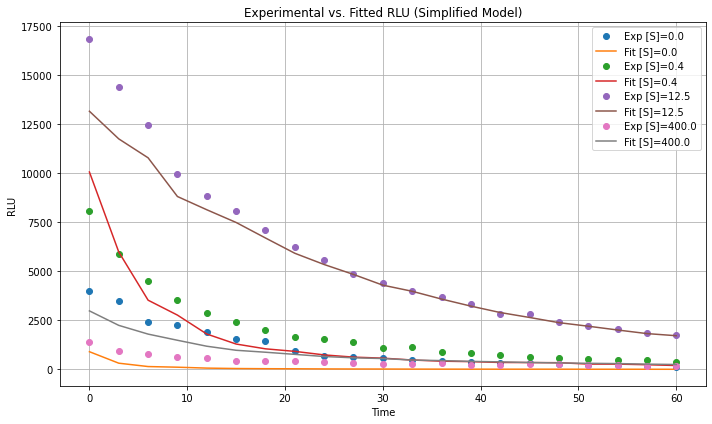

In [12]:
fitted_params_df = fit_all_timepoints("data0.xlsx", plot_indices=[0, 5, 10, 15], export_csv=False)

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import os

# -----------------------------
# Load and preprocess the data
# -----------------------------
def load_data(filepath):
    df = pd.read_excel(filepath, header=None)
    # First row (excluding the first cell) contains substrate concentrations (in µM)
    substrate_conc = df.iloc[0, 1:].astype(float).values  
    # First column (from second row onward) contains time points (in minutes)
    time_points = df.iloc[1:, 0].astype(float).values  
    # Remaining cells contain RLU values
    rlu_matrix = df.iloc[1:, 1:].astype(float).values  

    # Average every 3 columns (triplicates)
    n_reps = 3
    n_groups = rlu_matrix.shape[1] // n_reps
    substrate_avg = np.array([np.mean(substrate_conc[i*n_reps:(i+1)*n_reps])
                               for i in range(n_groups)])
    rlu_avg = np.stack([
        np.mean(rlu_matrix[:, i*n_reps:(i+1)*n_reps], axis=1)
        for i in range(n_groups)
    ], axis=1)

    # Downsample time points (take every 3rd point)
    time_subset = time_points[::3]
    rlu_subset = rlu_avg[::3, :]

    return substrate_avg, time_subset, rlu_subset

# -----------------------------
# Dose–response model with substrate inhibition
# -----------------------------
def dose_response(S, Vmax, Km, Ki):
    # Model: y = (Vmax * S) / (Km + S + (S^2)/Ki)
    S = np.asarray(S)
    return (Vmax * S) / (Km + S + (S**2) / Ki)

# -----------------------------
# Main processing and plotting
# -----------------------------
# Load the data from the Excel file (update filename if needed)
filepath = "data0.xlsx"
substrate_avg, time_subset, rlu_subset = load_data(filepath)

# Prepare a DataFrame to store the fitted parameters for each time point.
param_table = pd.DataFrame(columns=["Time (min)", "Vmax", "Km", "Ki", "Max_value"])

# Create a combined figure for all fitted curves.
plt.figure(figsize=(10, 8))

# Set up a colormap for the time gradient.
norm = plt.Normalize(vmin=min(time_subset), vmax=max(time_subset))
cmap = plt.cm.viridis

# Generate a smooth substrate concentration range for plotting the fitted curves.
S_fit = np.linspace(min(substrate_avg), max(substrate_avg), 100)

# Loop over each time point, fit the curve, and plot.
for i, t in enumerate(time_subset):
    y = rlu_subset[i, :]  # data at current time point
    # Initial guess: Vmax as max observed signal, Km ~ median substrate, Ki ~ max substrate
    p0 = [max(y), np.median(substrate_avg), max(substrate_avg)]
    try:
        popt, _ = curve_fit(dose_response, substrate_avg, y, p0=p0, maxfev=10000)
        Vmax_fit, Km_fit, Ki_fit = popt
        y_fit = dose_response(S_fit, Vmax_fit, Km_fit, Ki_fit)
        max_value = np.max(y_fit)
    except Exception as e:
        print(f"Fit failed at time {t} min: {e}")
        Vmax_fit, Km_fit, Ki_fit, max_value = np.nan, np.nan, np.nan, np.nan

    # Append fitted parameters for the current time point.
    param_table = param_table.append({
        "Time (min)": t,
        "Vmax": Vmax_fit,
        "Km": Km_fit,
        "Ki": Ki_fit,
        "Max_value": max_value
    }, ignore_index=True)
    
    # Determine color for this time point based on the colormap.
    color = cmap(norm(t))
    # Plot the fitted curve.
    plt.plot(S_fit, y_fit, color=color)
    # Also overlay the original data points.
    plt.scatter(substrate_avg, y, color=color, edgecolor='k', s=30)

# Add colorbar to indicate time.
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm)
cbar.set_label("Time (min)")

plt.xlabel("Substrate (µM)")
plt.ylabel("RLU")
plt.title("Dose–Response Curves Over Time")
plt.xscale("log")
plt.tight_layout()

# Create folder "fig" if it doesn't exist and save the combined figure.
os.makedirs("fig", exist_ok=True)
plt.savefig("fig/combined_curves.png")
plt.close()

# Save the parameter table to an Excel file.
param_table.to_excel("fitting_parameters.xlsx", index=False)

print("Processing complete.")
print("Combined figure saved in the 'fig' folder and parameter table in 'fitting_parameters.xlsx'.")


Processing complete.
Combined figure saved in the 'fig' folder and parameter table in 'fitting_parameters.xlsx'.


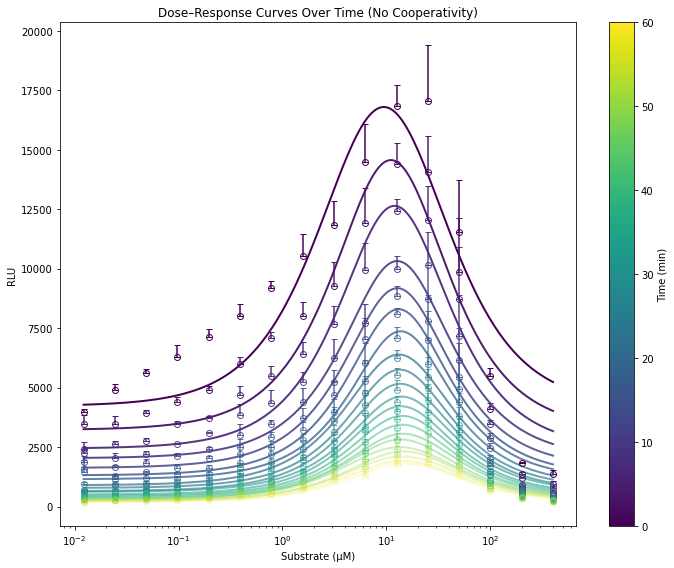

Processing complete.
Combined figure saved in 'fig' folder and parameter table in 'fitting_parameters.xlsx'.


In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import os

# -----------------------------
# Load and preprocess the data
# -----------------------------
def load_data(filepath):
    df = pd.read_excel(filepath, header=None)
    # First row (excluding the first cell) contains substrate concentrations (in µM)
    substrate_conc = df.iloc[0, 1:].astype(float).values  
    # First column (from row 1 onward) contains time points (in minutes)
    time_points = df.iloc[1:, 0].astype(float).values  
    # Remaining cells contain RLU values
    rlu_matrix = df.iloc[1:, 1:].astype(float).values  

    # Average every 3 columns (triplicates)
    n_reps = 3
    n_groups = rlu_matrix.shape[1] // n_reps
    substrate_avg = np.array([np.mean(substrate_conc[i*n_reps:(i+1)*n_reps])
                               for i in range(n_groups)])
    rlu_avg = np.stack([
        np.mean(rlu_matrix[:, i*n_reps:(i+1)*n_reps], axis=1)
        for i in range(n_groups)
    ], axis=1)
    # Compute standard deviation for error bars
    rlu_std = np.stack([
        np.std(rlu_matrix[:, i*n_reps:(i+1)*n_reps], axis=1)
        for i in range(n_groups)
    ], axis=1)

    # Take all time points (no downsampling)
    time_subset = time_points
    rlu_subset = rlu_avg
    rlu_err = rlu_std

    return substrate_avg, time_subset, rlu_subset, rlu_err

# -----------------------------
# Dose–response model without cooperativity
# -----------------------------
def dose_response(S, Vmin, Vmax, Km, Ki):
    # Model:
    # y = Vmin + (Vmax - Vmin)*S / (Km + S + (S^2)/Ki)
    S = np.asarray(S)
    return Vmin + (Vmax - Vmin) * S / (Km + S + (S**2) / Ki)

# -----------------------------
# Main processing and plotting
# -----------------------------
filepath = "data0.xlsx"  # Update to your file name if needed
substrate_avg, time_subset, rlu_subset, rlu_err = load_data(filepath)

# Prepare a DataFrame to store fitted parameters.
# We record: Time (min), Vmin, Vmax, Km, Ki, and the maximum value (Max_value) of the fitted curve.
param_table = pd.DataFrame(columns=["Time (min)", "Vmin", "Vmax", "Km", "Ki", "Max_value"])

# Create a combined figure.
plt.figure(figsize=(10, 8))

# Set up a colormap for the time gradient.
norm = plt.Normalize(vmin=min(time_subset), vmax=max(time_subset))
cmap = plt.cm.viridis

# For transparency: alpha decreases from 1 (earliest) to 0.2 (latest)
t_min = min(time_subset)
t_max = max(time_subset)

# Generate substrate concentration points evenly spaced in log scale.
S_fit = np.logspace(np.log10(min(substrate_avg)), np.log10(max(substrate_avg)), 200)

# Loop over each time point.
for i, t in enumerate(time_subset):
    y = rlu_subset[i, :]  # Data at time t
    y_err = rlu_err[i, :]  # Error for data at time t
    
    # Initial guess:
    # Vmin: minimum observed RLU,
    # Vmax: maximum observed RLU,
    # Km: median substrate concentration,
    # Ki: maximum substrate concentration.
    p0 = [min(y), max(y), np.median(substrate_avg), max(substrate_avg)]
    
    try:
        popt, _ = curve_fit(dose_response, substrate_avg, y, p0=p0, maxfev=10000)
        Vmin_fit, Vmax_fit, Km_fit, Ki_fit = popt
        y_fit = dose_response(S_fit, Vmin_fit, Vmax_fit, Km_fit, Ki_fit)
        max_value = np.max(y_fit)
    except Exception as e:
        print(f"Fit failed at time {t} min: {e}")
        Vmin_fit, Vmax_fit, Km_fit, Ki_fit, max_value = [np.nan] * 5

    # Append fitted parameters.
    param_table = param_table.append({
        "Time (min)": t,
        "Vmin": Vmin_fit,
        "Vmax": Vmax_fit,
        "Km": Km_fit,
        "Ki": Ki_fit,
        "Max_value": max_value
    }, ignore_index=True)
    
    # Determine the color and transparency for this time point.
    color = cmap(norm(t))
    alpha_val = 1 - ((t - t_min) / (t_max - t_min)) * 0.8
    
    # Plot the fitted curve.
    plt.plot(S_fit, y_fit, color=color, lw=2, alpha=alpha_val)
    
    # Prepare one-sided error bars (only upward error; lower error = 0).
    y_err_asym = [np.zeros_like(y_err), y_err]
    
    # Plot the data with error bars: markers with no fill (only outlined) and one-sided error bar.
    plt.errorbar(substrate_avg, y, yerr=y_err_asym, fmt='o', 
                 markerfacecolor='none', markeredgecolor=color, 
                 ecolor=color, capsize=3, alpha=alpha_val)

# Add a colorbar to indicate time.
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm)
cbar.set_label("Time (min)")

plt.xlabel("Substrate (µM)")
plt.ylabel("RLU")
plt.title("Dose–Response Curves Over Time (No Cooperativity)")
plt.xscale("log")  # x-axis on log scale; y-axis remains linear
plt.tight_layout()

# Create folder "fig" if it doesn't exist and save the combined figure.
os.makedirs("fig", exist_ok=True)
plt.savefig("fig/combined_curves_no_coop_transparent_error.png")
plt.show()  # Display the plot

# Save the parameter table to an Excel file.
param_table.to_excel("fitting_parameters_n.xlsx", index=False)

print("Processing complete.")
print("Combined figure saved in 'fig' folder and parameter table in 'fitting_parameters.xlsx'.")


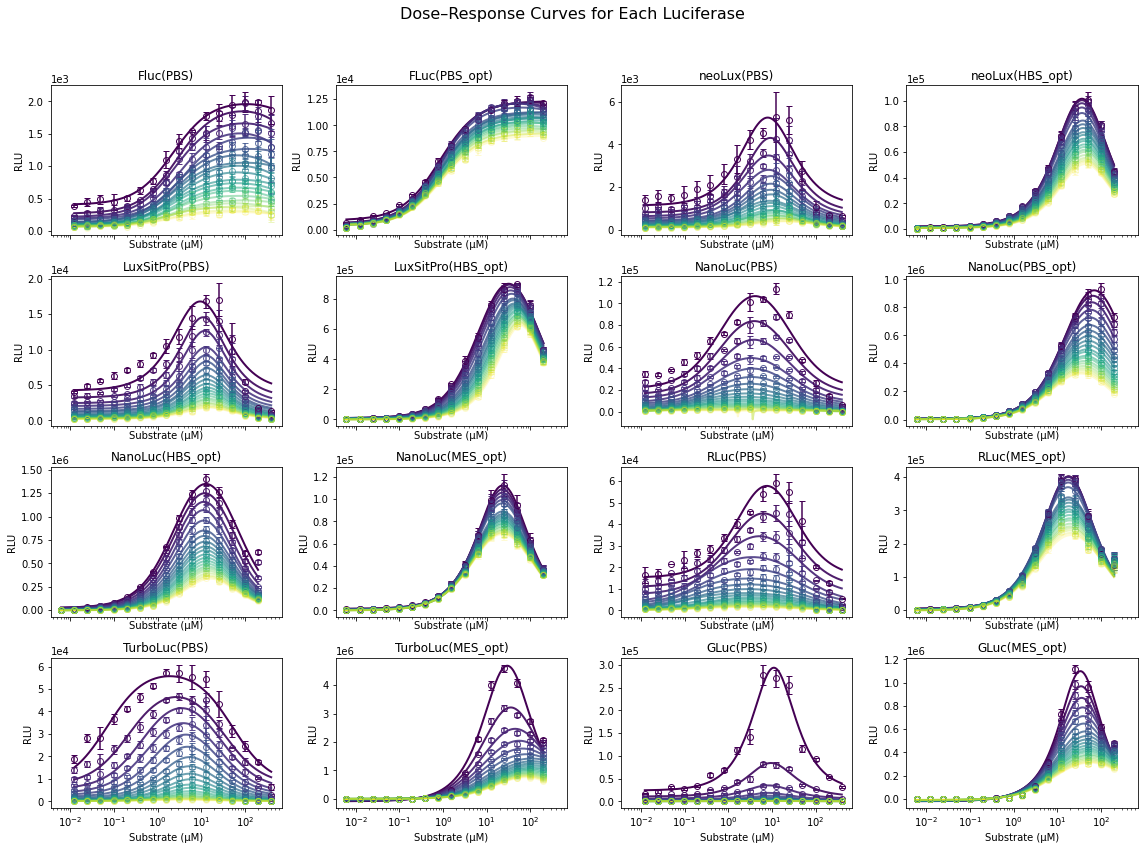

Processing complete.
Combined figure saved in 'fig/combined_luciferase_plots_grid.png' and fitting parameters saved in 'fitting_parameters.xlsx'.


In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import os
import math

# -----------------------------
# Function to load data from a given sheet
# -----------------------------
def load_data_from_sheet(filepath, sheet):
    df = pd.read_excel(filepath, sheet_name=sheet, header=None)
    # First row (excluding first cell): substrate concentrations (in µM)
    substrate_conc = df.iloc[0, 1:].astype(float).values  
    # First column (from row 1 onward): time points (in minutes)
    time_points = df.iloc[1:, 0].astype(float).values  
    # Remaining cells: RLU measurements
    rlu_matrix = df.iloc[1:, 1:].astype(float).values  

    # Average every 3 columns (triplicates)
    n_reps = 3
    n_groups = rlu_matrix.shape[1] // n_reps
    substrate_avg = np.array([
        np.mean(substrate_conc[i*n_reps:(i+1)*n_reps])
        for i in range(n_groups)
    ])
    rlu_avg = np.stack([
        np.mean(rlu_matrix[:, i*n_reps:(i+1)*n_reps], axis=1)
        for i in range(n_groups)
    ], axis=1)
    # Standard deviation for error bars
    rlu_std = np.stack([
        np.std(rlu_matrix[:, i*n_reps:(i+1)*n_reps], axis=1)
        for i in range(n_groups)
    ], axis=1)
    
    return substrate_avg, time_points, rlu_avg, rlu_std

# -----------------------------
# Dose–response model without cooperativity
# -----------------------------
def dose_response(S, Vmin, Vmax, Km, Ki):
    # y = Vmin + (Vmax - Vmin)*S / (Km + S + (S^2)/Ki)
    S = np.asarray(S)
    return Vmin + (Vmax - Vmin) * S / (Km + S + (S**2)/Ki)

# -----------------------------
# Main script to generate grid of plots and save fitting parameters
# -----------------------------
filepath = "data1.xlsx"  # Update with your data file name
xls = pd.ExcelFile(filepath)
sheet_names = xls.sheet_names
num_sheets = len(sheet_names)

# Determine grid dimensions: 4 columns, as many rows as needed.
ncols = 4
nrows = math.ceil(num_sheets / ncols)

# Create the overall figure; share x-axis so that substrate scale is consistent.
fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 3*nrows), sharex=True)
axes = axes.flatten()

# Create folder "fig" if it doesn't exist.
os.makedirs("fig", exist_ok=True)

# Dictionary to store parameter DataFrames for each sheet.
parameter_tables = {}

# Loop over each sheet (each luciferase dataset)
for idx, sheet in enumerate(sheet_names):
    ax = axes[idx]
    substrate_avg, time_subset, rlu_avg, rlu_std = load_data_from_sheet(filepath, sheet)
    
    # Set up a colormap for the time gradient in this dataset.
    norm = plt.Normalize(vmin=min(time_subset), vmax=max(time_subset))
    cmap = plt.cm.viridis
    t_min = min(time_subset)
    t_max = max(time_subset)
    
    # Generate substrate points evenly spaced in log scale for a smooth fitted curve.
    S_fit = np.logspace(np.log10(min(substrate_avg)), np.log10(max(substrate_avg)), 200)
    
    # DataFrame to store parameters for each time point in the current sheet.
    param_df = pd.DataFrame(columns=["Time (min)", "Vmin", "Vmax", "Km", "Ki", "Peak"])
    
    # Loop over each time point.
    for i, t in enumerate(time_subset):
        y = rlu_avg[i, :]
        y_err = rlu_std[i, :]
        # Initial guesses: Vmin from minimum observed, Vmax from maximum observed, Km ~ median substrate, Ki ~ maximum substrate.
        p0 = [min(y), max(y), np.median(substrate_avg), max(substrate_avg)]
        try:
            popt, _ = curve_fit(dose_response, substrate_avg, y, p0=p0, maxfev=10000)
            Vmin_fit, Vmax_fit, Km_fit, Ki_fit = popt
            y_fit = dose_response(S_fit, Vmin_fit, Vmax_fit, Km_fit, Ki_fit)
            peak = np.max(y_fit)
        except Exception as e:
            print(f"Fit failed for sheet '{sheet}' at time {t} min: {e}")
            Vmin_fit, Vmax_fit, Km_fit, Ki_fit, peak = [np.nan]*5
        
        # Append the parameters for the current time point.
        param_df = param_df.append({
            "Time (min)": t,
            "Vmin": Vmin_fit,
            "Vmax": Vmax_fit,
            "Km": Km_fit,
            "Ki": Ki_fit,
            "Peak": peak
        }, ignore_index=True)
        
        # Determine the color and transparency (alpha) for this time point.
        color = cmap(norm(t))
        alpha_val = 1 - ((t - t_min) / (t_max - t_min)) * 0.8
        
        # Plot the fitted curve.
        ax.plot(S_fit, dose_response(S_fit, Vmin_fit, Vmax_fit, Km_fit, Ki_fit),
                color=color, lw=2, alpha=alpha_val)
        # Plot the original data with symmetric error bars (both sides).
        ax.errorbar(substrate_avg, y, yerr=y_err, fmt='o',
                    markerfacecolor='none', markeredgecolor=color,
                    ecolor=color, capsize=3, alpha=alpha_val)
    
    # Store the parameter DataFrame for this sheet.
    parameter_tables[sheet] = param_df.copy()
    
    # Set x-axis to log scale and format y-axis in scientific notation.
    ax.set_xscale("log")
    ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
    ax.set_xlabel("Substrate (µM)")
    ax.set_ylabel("RLU")
    ax.set_title(sheet)

# Remove any unused subplots.
for j in range(num_sheets, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle("Dose–Response Curves for Each Luciferase", fontsize=16)
fig.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("fig/combined_luciferase_plots_grid.png")
plt.show()

# Save all parameter tables into a single Excel file with one sheet per luciferase.
with pd.ExcelWriter("fitting_parameters.xlsx") as writer:
    for sheet, df_param in parameter_tables.items():
        df_param.to_excel(writer, sheet_name=sheet, index=False)

print("Processing complete.")
print("Combined figure saved in 'fig/combined_luciferase_plots_grid.png' and fitting parameters saved in 'fitting_parameters.xlsx'.")
